# Map-based simulation for differential pointing

## Here, we introduce how to assess differential pointing systematics by the map-based simulation in the case of a single detector on the boresight.


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from sbm import Field, ScanFields, SignalFields
import sbm

# Load the cross-link on the boresight detector

## Input map: CMB (r=0), Gaussian beam smoothing (1 deg for FWHM)


In [2]:
# Load single detector map
scan_field = ScanFields.load_det("boresight/boresight")
fiducial_map = hp.read_map("../maps/cmb_0000_nside_128_seed_33.fits", field=(0,1,2)) * 1e6

fwhm = np.deg2rad(1.0)
input_map = hp.smoothing(fiducial_map, fwhm)
nside = hp.npix2nside(len(input_map[0]))
lmax = 3*nside-1
bl = hp.gauss_beam(fwhm, lmax=lmax, pol=True)

# Set a differential pointing parameter

$\rho$ (`rho`): a magnitude of pointing offset between detector A and B, which makes an orthogonal pair.

$\chi$ (`chi`): a pointing offset direction

Here, we set $(\rho, \chi)=(1,0)$ arcmin differential pointing.


In [3]:
I = input_map[0]
P = input_map[1] + 1j*input_map[2]
dI = hp.alm2map_der1(hp.map2alm(input_map[0]), nside=nside)
dQ = hp.alm2map_der1(hp.map2alm(input_map[1]), nside=nside)
dU = hp.alm2map_der1(hp.map2alm(input_map[2]), nside=nside)

eth_I = dI[2] - dI[1]*1j
eth_P = dQ[2] + dU[1] - (dQ[1] - dU[2])*1j
o_eth_P = dQ[2] - dU[1] + 1j*(dQ[1] + dU[2])

rho_T = np.deg2rad(1/60)
rho_B = np.deg2rad(0)
chi_T = np.deg2rad(0)
chi_B = np.deg2rad(0)

zeta   = rho_T * np.exp(1j*chi_T) - 1j*rho_B * np.exp(1j*chi_B)
o_zeta = rho_T * np.exp(1j*chi_T) + 1j*rho_B * np.exp(1j*chi_B)

spin_1_field  = Field(-1.0/4.0 * (zeta*eth_I + o_zeta.conj()*o_eth_P), spin_n=1, spin_m=0)
spin_m1_field = spin_1_field.conj()
spin_2_field  = Field(P/2.0, spin_n=2, spin_m=0)
spin_m2_field = spin_2_field.conj()
spin_3_field  = Field(-1.0/4.0 * o_zeta * eth_P, spin_n=3, spin_m=0)
spin_m3_field = spin_3_field.conj()

signal_field = SignalFields(
    spin_1_field,
    spin_m1_field,
    spin_2_field,
    spin_m2_field,
    spin_3_field,
    spin_m3_field,
)

# Couple the signal field with the scan field


In [4]:
s_0 = signal_field.get_coupled_field(scan_field, spin_n_out=0, spin_m_out=0)
sp2 = signal_field.get_coupled_field(scan_field, spin_n_out=2, spin_m_out=0)
signal_field.coupled_fields = np.array([sp2/2.0, sp2.conj()/2.0])
signal_field.spin_n_basis = [2,-2]
signal_field.spin_m_basis = [0,0]

# Solve the liner system

Detailed discription coming soon...

Here, we perform the map-making by 3x3 matrix.


In [5]:
output_map = scan_field.map_make(signal_field, only_iqu=True)
residual = input_map - output_map

# Let's check the Input/Output/Residual maps

Especially, we can see that the residual map (Q and U) which is reconstructed by 3x3 noise covariant matrix are contaminated by the systematics


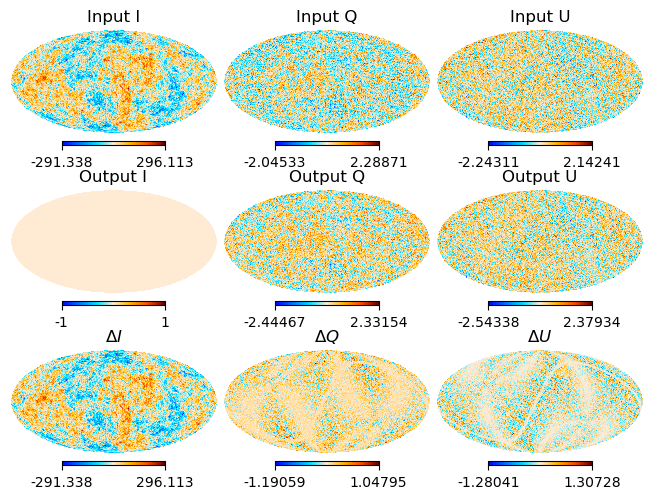

In [6]:
cmap = sbm.get_cmap()
hp.mollview(input_map[0], title="Input I", sub=(3,3,1), cmap=cmap)
hp.mollview(input_map[1], title="Input Q", sub=(3,3,2), cmap=cmap)
hp.mollview(input_map[2], title="Input U", sub=(3,3,3), cmap=cmap)

# SBM does not reconstruct I if `only_iqu`` is True
hp.mollview(output_map[0], title="Output I", sub=(3,3,4), cmap=cmap)
hp.mollview(output_map[1], title="Output Q", sub=(3,3,5), cmap=cmap)
hp.mollview(output_map[2], title="Output U", sub=(3,3,6), cmap=cmap)

hp.mollview(residual[0], title="$\Delta I$", sub=(3,3,7), cmap=cmap)
hp.mollview(residual[1], title="$\Delta Q$", sub=(3,3,8), cmap=cmap)
hp.mollview(residual[2], title="$\Delta U$", sub=(3,3,9), cmap=cmap)

# Let's check the power spectra

The green line shows systematics power spectrum, i.e., $\Delta C_\ell^{BB}$, which is obtained by residual map.

Althogh the green line is providing an exact solution which agrees with the binning map-making, we can perform an analitical estimation without doing the map-making.

The red line $\Delta C_{\ell, Ana}^{BB}$ is simulated by

$$
\Delta C_{\ell, Ana}^{BB} = \frac{1}{8}(\langle|{}_{1}\tilde{h}|^2\rangle + \langle|{}_{3}\tilde{h}|^2\rangle)~\rho^2~\ell^2~C_{\ell}^{TT}
$$

where $\langle|{}_{n}\tilde{h}|^2\rangle$ represents the entire sky average of the spin-n cross-link (See [C.G.R. Wallis et al.](https://arxiv.org/abs/1604.02290)).


'\nplt.savefig("./figures/pointing_bore_cl_2x2.pdf")\nplt.figure()\nhp.mollview(residual[1], title="$\\Delta Q$", cmap=cmap, unit="$\\mu K_{CMB}$")\nplt.savefig("./figures/pointing_bore_dQ_2x2.pdf")\nplt.figure()\nhp.mollview(residual[2], title="$\\Delta U$", cmap=cmap, unit="$\\mu K_{CMB}$")\nplt.savefig("./figures/pointing_bore_dU_2x2.pdf")\n'

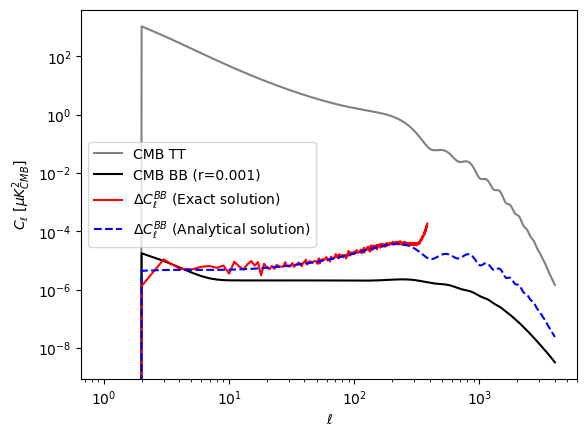

In [7]:
r = 0.001
fiducial_cl = sbm.load_fiducial_cl(r)
res_cl = hp.anafast(residual)

ell = np.arange(len(fiducial_cl[0]))
xlink1_mean = np.mean(np.abs(scan_field.get_xlink(1,0))**2)
xlink3_mean = np.mean(np.abs(scan_field.get_xlink(3,0))**2)

ana = 1/8*(xlink1_mean + xlink3_mean) * fiducial_cl[0] * rho_T**2 * ell**2

plt.plot(fiducial_cl[0], label="CMB TT", color="gray")
plt.plot(fiducial_cl[2], label=f"CMB BB (r={r})", color="black")
plt.plot(res_cl[2] / bl[:,2]**2, label="$\Delta C_\ell^{BB}$ (Exact solution)", color="red") # deconvolution
plt.plot(ana, "--", label="$\Delta C_\ell^{BB}$ (Analytical solution)", color="blue")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K_{CMB}^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend();
"""
plt.savefig("./figures/pointing_bore_cl_2x2.pdf")
plt.figure()
hp.mollview(residual[1], title="$\Delta Q$", cmap=cmap, unit="$\mu K_{CMB}$")
plt.savefig("./figures/pointing_bore_dQ_2x2.pdf")
plt.figure()
hp.mollview(residual[2], title="$\Delta U$", cmap=cmap, unit="$\mu K_{CMB}$")
plt.savefig("./figures/pointing_bore_dU_2x2.pdf")
"""

# Mitigation method

By chapturing $spin$-$\pm$1 component, we can avoid to have tempereture-to-polarization leakage.
TO do it, we expand the matrix size 2x2 to 5x5 as below


In [8]:
mdim = 4
signal_field = SignalFields.diff_pointing_field(
    scan_field,
    mdim,
    rho_T,
    rho_B,
    chi_T,
    chi_B,
    P,
    eth_I,
    eth_P,
    o_eth_P,
)
output_map = scan_field.map_make(signal_field)
residual = input_map - output_map

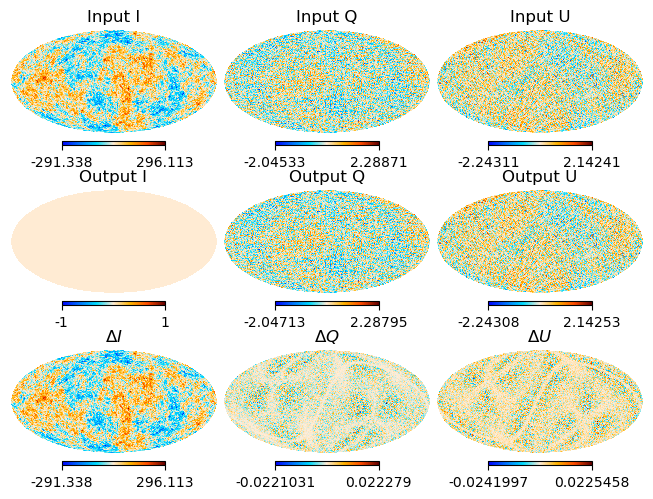

In [9]:
hp.mollview(input_map[0], title="Input I", sub=(3,3,1), cmap=cmap)
hp.mollview(input_map[1], title="Input Q", sub=(3,3,2), cmap=cmap)
hp.mollview(input_map[2], title="Input U", sub=(3,3,3), cmap=cmap)

# SBM does not reconstruct I if `only_iqu`` is True
hp.mollview(output_map[0], title="Output I", sub=(3,3,4), cmap=cmap)
hp.mollview(output_map[1], title="Output Q", sub=(3,3,5), cmap=cmap)
hp.mollview(output_map[2], title="Output U", sub=(3,3,6), cmap=cmap)

hp.mollview(residual[0], title="$\Delta I$", sub=(3,3,7), cmap=cmap)
hp.mollview(residual[1], title="$\Delta Q$", sub=(3,3,8), cmap=cmap)
hp.mollview(residual[2], title="$\Delta U$", sub=(3,3,9), cmap=cmap)

'\nplt.savefig("./figures/pointing_bore_cl_4x4.pdf")\nplt.figure()\nhp.mollview(residual[1], title="$\\Delta Q$", cmap=cmap, unit="$\\mu K_{CMB}$")\nplt.savefig("./figures/pointing_bore_dQ_3x3.pdf")\nplt.figure()\nhp.mollview(residual[2], title="$\\Delta U$", cmap=cmap, unit="$\\mu K_{CMB}$")\nplt.savefig("./figures/pointing_bore_dU_3x3.pdf")\n'

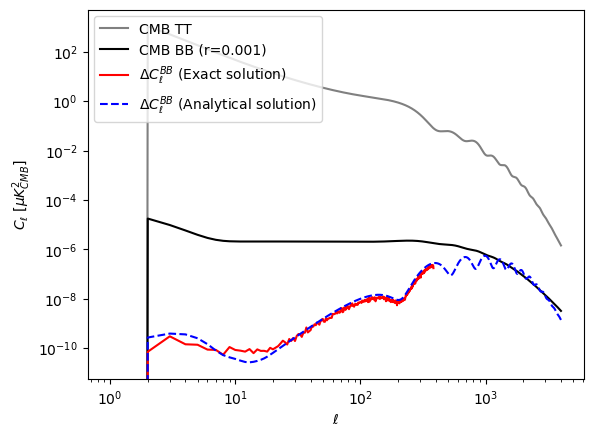

In [10]:
fiducial_cl = sbm.load_fiducial_cl(r)#hp.anafast(fiducial_map)
res_cl = hp.anafast(residual)

ell = np.arange(len(fiducial_cl[0]))
xlink1_mean = np.mean(np.abs(scan_field.get_xlink(1,0))**2)
xlink3_mean = np.mean(np.abs(scan_field.get_xlink(3,0))**2)

ana = 1/4*(xlink1_mean + xlink3_mean) * fiducial_cl[1] * rho_T**2 * ell**2

plt.plot(fiducial_cl[0], label="CMB TT", color="gray")
plt.plot(fiducial_cl[2], label=f"CMB BB (r={r})", color="black")
plt.plot(res_cl[2] / bl[:,2]**2, label="$\Delta C_\ell^{BB}$ (Exact solution)", color="red") # deconvolution
plt.plot(ana, "--", label="$\Delta C_\ell^{BB}$ (Analytical solution)", color="blue")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K_{CMB}^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend();
"""
plt.savefig("./figures/pointing_bore_cl_4x4.pdf")
plt.figure()
hp.mollview(residual[1], title="$\Delta Q$", cmap=cmap, unit="$\mu K_{CMB}$")
plt.savefig("./figures/pointing_bore_dQ_3x3.pdf")
plt.figure()
hp.mollview(residual[2], title="$\Delta U$", cmap=cmap, unit="$\mu K_{CMB}$")
plt.savefig("./figures/pointing_bore_dU_3x3.pdf")
"""